## Notebook 5: Model Training & Evaluation (Heart Disease Dataset)

In this notebook, we train candidate machine learning models on the processed dataset and evaluate their performance to identify the best model for deployment.

### **Goals**

- Train multiple candidate models (Logistic Regression, Random Forest, XGBoost, LightGBM)  

- Perform hyperparameter tuning for each model  

- Evaluate models on validation data using key metrics (ROC-AUC, accuracy, F1-score)  

- Compare model performance and select the best-performing pipeline  

### **Workflow**

1. Load preprocessed training, validation, and test datasets  

2. Define model pipelines for each candidate algorithm  

3. Train models with hyperparameter tuning where applicable  

4. Evaluate models on the validation set and collect metrics  

5. Compare performances to determine the best model for deployment  

By the end of this notebook, we will have the best-performing model pipeline ready for final evaluation and deployment in Notebook 6.


---


## 5.1 Imports

Purpose

Bring in previously saved train/val/test splits and baseline pipelines for evaluation and tuning.

Approach

- Load splits_v2.pkl and baseline_models_v2.pkl using joblib.

- Print shapes to verify load.

Expected Outcome

X_train, X_val, X_test, y_train, y_val, y_test and baseline_models are available for analysis.

In [1]:

import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score, RocCurveDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


In [2]:
X_train, X_val, X_test, y_train, y_val, y_test = joblib.load("/workspaces/Heart_disease_risk_predictor/outputs/models/splits.pkl")
baseline_models = joblib.load("/workspaces/Heart_disease_risk_predictor/outputs/models/baseline_models.pkl")

print("✅ Data splits and baseline models loaded")
print("Train shape:", X_train.shape, "Validation shape:", X_val.shape, "Test shape:", X_test.shape)


✅ Data splits and baseline models loaded
Train shape: (644, 22) Validation shape: (138, 22) Test shape: (138, 22)


---

## 5.2 Helper Function: Evaluate Models

Purpose

Standardize evaluation of all models for consistent metrics and visualization.

Approach

- Print classification_report (precision, recall, F1, support).

- Compute ROC-AUC.

- Plot confusion matrix and ROC curve.

Expected Outcome

Reusable function evaluate_model(...) that can handle any model and dataset.


In [3]:
def evaluate_model(y_true, y_pred, y_proba, model_name):
    print(f"--- {model_name} ---")
    print(classification_report(y_true, y_pred, digits=3))
    print("ROC-AUC:", roc_auc_score(y_true, y_proba))
    
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    RocCurveDisplay.from_predictions(y_true, y_proba)
    plt.title(f"{model_name} - ROC Curve")
    plt.show()

---

## 5.3 Baseline Evaluation on Validation Set (Optional and for Verification only)

Purpose

Check performance of pre-trained baseline models on validation data before tuning.

Approach

- Verify performance of pre-trained baseline models on validation set.
  
- Store metrics for later comparison with tuned models.

**Note**: Plots are optional; only metrics are strictly needed for workflow.

Expected Outcome

Baseline validation metrics for accuracy, F1, and ROC-AUC.

In [4]:
baseline_results = []

for name, model in baseline_models.items():
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]
    
    # Optional: Uncomment to plot confusion matrix & ROC curve
    # evaluate_model(y_val, y_val_pred, y_val_proba, f"{name} (Baseline)")
    
    # Store metrics
    baseline_results.append({
        "Model": name,
        "Dataset": "Validation",
        "Accuracy": (y_val_pred == y_val).mean(),
        "F1": f1_score(y_val, y_val_pred),
        "ROC-AUC": roc_auc_score(y_val, y_val_proba)
    })

baseline_df = pd.DataFrame(baseline_results)
baseline_df

,Model,Dataset,Accuracy,F1,ROC-AUC
0,Logistic Regression,Validation,0.753623,0.779221,0.813711
1,Random Forest,Validation,0.818841,0.844720,0.886949
2,Logistic Regression + SMOTE,Validation,0.746377,0.765101,0.816479
3,XGBoost,Validation,0.789855,0.817610,0.880136
4,LightGBM,Validation,0.804348,0.828025,0.878007


---

## 5.4 Hyperparameter Tuning (GridSearchCV)

Purpose

Optimize model hyperparameters to improve validation performance.

Approach

- Define search grids for Logistic Regression, Random Forest, XGBoost, LightGBM.

- Use 5-fold StratifiedKFold for cross-validation.

- Optimize based on F1-score.

Expected Outcome

Best hyperparameters for each model and tuned pipelines.

In [5]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

log_reg_params = {
    "log_reg__C": [0.01, 0.1, 1, 10],
    "log_reg__solver": ["liblinear"]
}

rf_params = {
    "rf__n_estimators": [100, 200],
    "rf__max_depth": [None, 5, 10],
    "rf__min_samples_split": [2, 5]
}

xgb_params = {
    "xgb__n_estimators": [100, 200],
    "xgb__max_depth": [3, 5, 7],
    "xgb__learning_rate": [0.01, 0.1, 0.2]
}

lgbm_params = {
    "lgbm__n_estimators": [100, 200],
    "lgbm__max_depth": [3, 5, 7],
    "lgbm__learning_rate": [0.01, 0.1, 0.2]
}

---

## 5.5 GridSearchCV for Logistic Regression and Random Forest

Purpose

Find the optimal hyperparameters for LR and RF pipelines.

Approach

- Apply GridSearchCV with predefined parameter grids and F1 scoring.

- Fit on training data.

- Print best parameters.

Expected Outcome

Best hyperparameters for Logistic Regression, Random Forest, XGBoost, and LightGBM.

In [6]:

grid_log = GridSearchCV(
    baseline_models["Logistic Regression"], log_reg_params, cv=cv, scoring="f1", return_train_score=True
)
grid_log.fit(X_train, y_train)

grid_rf = GridSearchCV(
    baseline_models["Random Forest"], rf_params, cv=cv, scoring="f1", return_train_score=True
)
grid_rf.fit(X_train, y_train)

grid_xgb = GridSearchCV(
    baseline_models["XGBoost"], xgb_params, cv=cv, scoring="f1", return_train_score=True
)
grid_xgb.fit(X_train, y_train)

grid_lgbm = GridSearchCV(
    baseline_models["LightGBM"], lgbm_params, cv=cv, scoring="f1", return_train_score=True
)
grid_lgbm.fit(X_train, y_train)

print("Best Logistic Regression params:", grid_log.best_params_)
print("Best Random Forest params:", grid_rf.best_params_)
print("Best XGBoost params:", grid_xgb.best_params_)
print("Best LightGBM params:", grid_lgbm.best_params_)

/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_spars

[LightGBM] [Info] Number of positive: 285, number of negative: 230
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 973
[LightGBM] [Info] Number of data points in the train set: 515, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553398 -> initscore=0.214410
[LightGBM] [Info] Start training from score 0.214410
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

---

## 5.6 Evaluate Tuned Models on Validation Set

Purpose

Check validation performance of tuned pipelines to compare against baseline.

Approach

- Generate predictions and probabilities for each tuned model.

- Evaluate using evaluate_model().

- Store metrics in a DataFrame.

Expected Outcome

Validation metrics (Accuracy, F1, ROC-AUC) for all tuned models.

--- Logistic Regression (Tuned) ---
              precision    recall  f1-score   support

           0      0.721     0.721     0.721        61
           1      0.779     0.779     0.779        77

    accuracy                          0.754       138
   macro avg      0.750     0.750     0.750       138
weighted avg      0.754     0.754     0.754       138

ROC-AUC: 0.8137108792846497


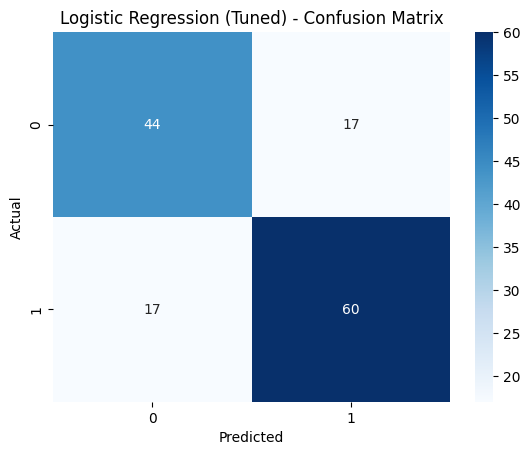

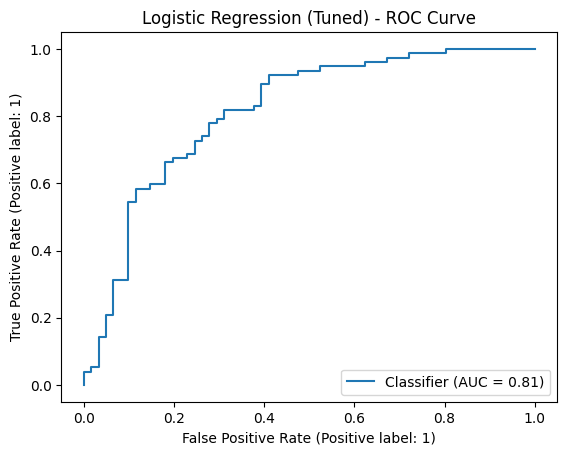

--- Random Forest (Tuned) ---
              precision    recall  f1-score   support

           0      0.833     0.738     0.783        61
           1      0.810     0.883     0.845        77

    accuracy                          0.819       138
   macro avg      0.821     0.810     0.814       138
weighted avg      0.820     0.819     0.817       138

ROC-AUC: 0.8829039812646369


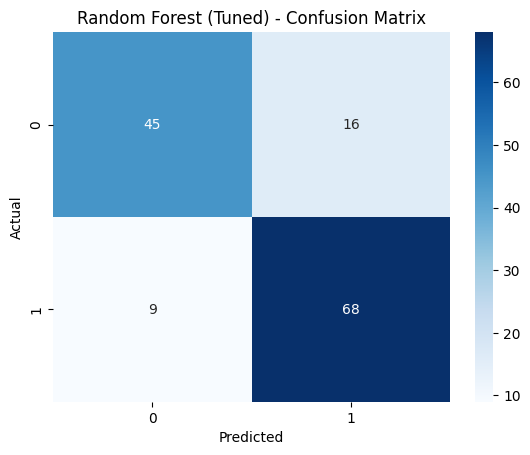

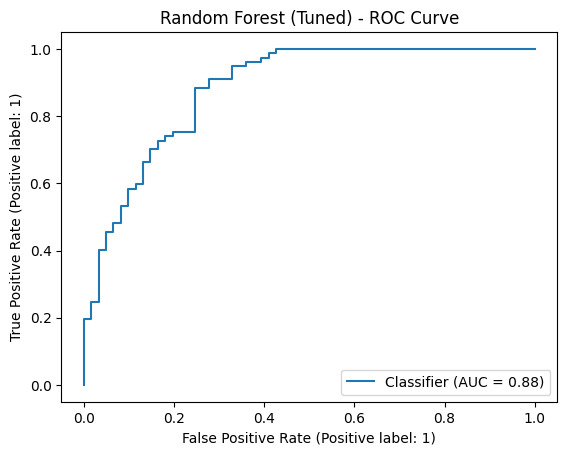

--- XGBoost (Tuned) ---
              precision    recall  f1-score   support

           0      0.821     0.754     0.786        61
           1      0.817     0.870     0.843        77

    accuracy                          0.819       138
   macro avg      0.819     0.812     0.815       138
weighted avg      0.819     0.819     0.818       138

ROC-AUC: 0.8904619970193741


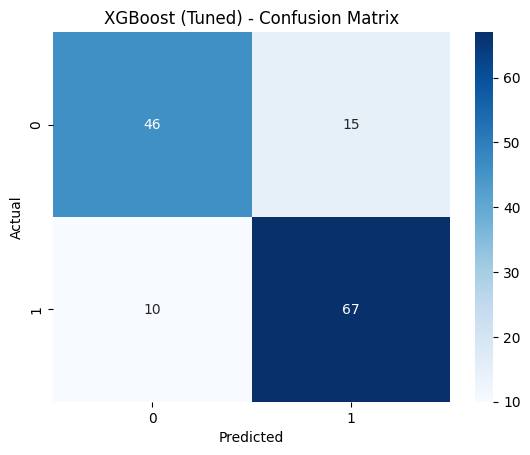

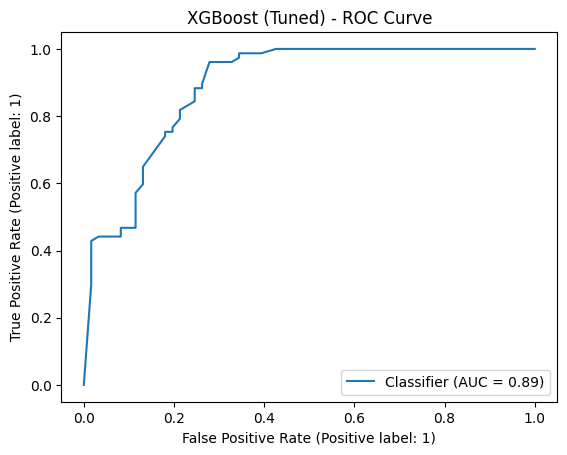

--- LightGBM (Tuned) ---
              precision    recall  f1-score   support

           0      0.818     0.738     0.776        61
           1      0.807     0.870     0.838        77

    accuracy                          0.812       138
   macro avg      0.813     0.804     0.807       138
weighted avg      0.812     0.812     0.810       138

ROC-AUC: 0.8971684053651267


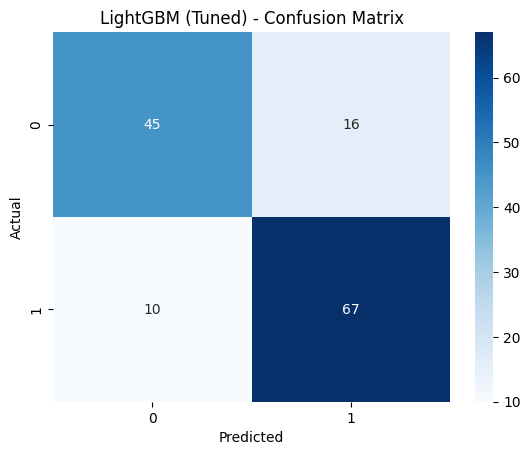

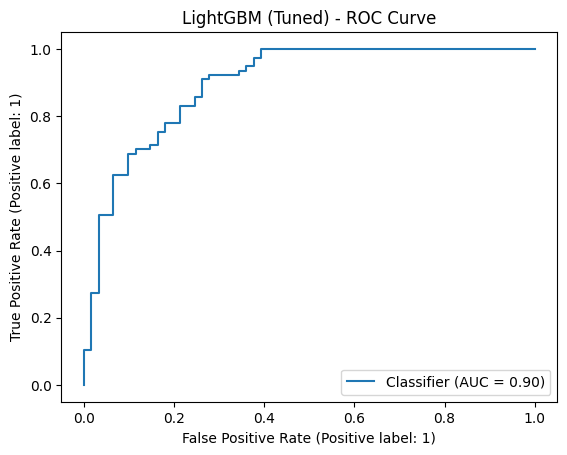

In [7]:
tuned_models = {
    "Logistic Regression": grid_log.best_estimator_,
    "Random Forest": grid_rf.best_estimator_,
    "XGBoost": grid_xgb.best_estimator_,
    "LightGBM": grid_lgbm.best_estimator_
}

tuned_results = []

for name, model in tuned_models.items():
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]
    
    evaluate_model(y_val, y_val_pred, y_val_proba, f"{name} (Tuned)")
    
    tuned_results.append({
        "Model": name,
        "Dataset": "Validation",
        "Accuracy": (y_val_pred == y_val).mean(),
        "F1": f1_score(y_val, y_val_pred),
        "ROC-AUC": roc_auc_score(y_val, y_val_proba)
    })

tuned_df = pd.DataFrame(tuned_results)

# --- Add suffix to indicate tuning ---
tuned_df["Model"] = tuned_df["Model"] + " (Tuned)"


## Results

- Validation Performance of Tuned Models

  - All four models improve after tuning; Random Forest and boosting models benefit the most.

- Confusion Matrices (Validation Set)

  - Tuned models show increased recall for heart disease cases compared to baseline.

- ROC Curves (Validation Set)

  - LightGBM and XGBoost maintain strongest discrimination (highest AUC); Logistic Regression remains weaker.

- Precision–Recall Curves

  - Boosting models achieve higher recall but trade off precision; Logistic Regression remains more conservative.

---

## 5.7 Summary: Baseline vs Tuned

Purpose

Compare performance of baseline and tuned models on the validation set to identify improvements from hyperparameter tuning.

Approach

- Concatenate baseline_df and tuned_df.

- Display key metrics: Accuracy, F1-score, ROC-AUC.

Expected Outcome

A single summary table showing the effect of tuning on each model.

In [8]:
comparison_df = pd.concat([baseline_df, tuned_df], ignore_index=True)
comparison_df

,Model,Dataset,Accuracy,F1,ROC-AUC
0,Logistic Regression,Validation,0.753623,0.779221,0.813711
1,Random Forest,Validation,0.818841,0.844720,0.886949
2,Logistic Regression + SMOTE,Validation,0.746377,0.765101,0.816479
3,XGBoost,Validation,0.789855,0.817610,0.880136
4,LightGBM,Validation,0.804348,0.828025,0.878007
5,Logistic Regression (Tuned),Validation,0.753623,0.779221,0.813711
6,Random Forest (Tuned),Validation,0.818841,0.844720,0.882904
7,XGBoost (Tuned),Validation,0.818841,0.842767,0.890462
8,LightGBM (Tuned),Validation,0.811594,0.837500,0.897168


---

## 5.8 Quick Ablation Test: Effect of num_id

Purpose

Test whether including the 'num_id' column affects model performance.

Approach

- Remove 'num_id' from all splits (train, val, test) using drop().

- For each model, compare accuracy with and without 'num_id'.

- Handle any errors gracefully if the pipeline fails with the modified input.

Expected Outcome

A table showing the change in accuracy (Delta) for each model when 'num_id' is removed.

In [9]:
# Drop the 'num_id' column from all splits
X_train_no_id = X_train.drop(columns=["num_id"], errors="ignore")
X_val_no_id = X_val.drop(columns=["num_id"], errors="ignore")
X_test_no_id = X_test.drop(columns=["num_id"], errors="ignore")

def ablation_test(models, X_val, X_val_no_id, y_val):
    results = []
    
    for name, model in models.items():
        # Predict with original validation set
        y_pred_with_id = model.predict(X_val)
        acc_with_id = (y_pred_with_id == y_val).mean()
        
        # Predict with ID dropped
        # Note: Some pipelines might break if 'num_id' was explicitly in training; we handle gracefully
        try:
            y_pred_no_id = model.predict(X_val_no_id)
            acc_no_id = (y_pred_no_id == y_val).mean()
        except Exception as e:
            acc_no_id = np.nan
            print(f"⚠️ {name} failed on X_val_no_id: {e}")
        
        results.append({
            "Model": name,
            "Accuracy_with_id": acc_with_id,
            "Accuracy_without_id": acc_no_id,
            "Delta": acc_with_id - acc_no_id
        })
    
    return pd.DataFrame(results)

# Baseline models
print("### Baseline Models Ablation")
baseline_ablation_df = ablation_test(baseline_models, X_val, X_val_no_id, y_val)
display(baseline_ablation_df)

# Tuned models
print("### Tuned Models Ablation")
tuned_ablation_df = ablation_test(tuned_models, X_val, X_val_no_id, y_val)
display(tuned_ablation_df)

### Baseline Models Ablation


,Model,Accuracy_with_id,Accuracy_without_id,Delta
0,Logistic Regression,0.753623,0.753623,0.0
1,Random Forest,0.818841,0.818841,0.0
2,Logistic Regression + SMOTE,0.746377,0.746377,0.0
3,XGBoost,0.789855,0.789855,0.0
4,LightGBM,0.804348,0.804348,0.0


### Tuned Models Ablation


,Model,Accuracy_with_id,Accuracy_without_id,Delta
0,Logistic Regression,0.753623,0.753623,0.0
1,Random Forest,0.818841,0.818841,0.0
2,XGBoost,0.818841,0.818841,0.0
3,LightGBM,0.811594,0.811594,0.0


---

## 5.9 Save Best Models for Deployment

Purpose

Persist tuned models to disk for future inference or deployment.

Approach

- Create directory 'models/tuned_v2'.

- Save each tuned pipeline as a .pkl file using joblib.

Expected Outcome

All tuned pipelines are saved and ready for downstream deployment.

In [10]:
final_tuned_dir = "/workspaces/Heart_disease_risk_predictor/outputs/models/tuned_models"
os.makedirs(final_tuned_dir, exist_ok=True)

for name, model in tuned_models.items():
    file_name = f"{final_tuned_dir}/best_{name.replace(' ', '_').lower()}_pipeline.pkl"
    joblib.dump(model, file_name)
    
print(f"✅ All tuned models saved in '{final_tuned_dir}'")

# 5.8 Save summary table
comparison_df = pd.concat([baseline_df, tuned_df], ignore_index=True)
comparison_df

# Save performance summary for Streamlit
summary_path = "/workspaces/Heart_disease_risk_predictor/outputs/models/model_performance_summary.csv"
comparison_df.to_csv(summary_path, index=False)
print(f"✅ Model performance summary saved to {summary_path}")

# Baseline models
print("### Baseline Models Ablation")
baseline_ablation_df = ablation_test(baseline_models, X_val, X_val_no_id, y_val)
display(baseline_ablation_df)

# Save baseline ablation results
baseline_ablation_path = "/workspaces/Heart_disease_risk_predictor/outputs/models/baseline_ablation.csv"
baseline_ablation_df.to_csv(baseline_ablation_path, index=False)
print(f"✅ Baseline ablation results saved to {baseline_ablation_path}")

# Tuned models
print("### Tuned Models Ablation")
tuned_ablation_df = ablation_test(tuned_models, X_val, X_val_no_id, y_val)
display(tuned_ablation_df)

# Save tuned ablation results
tuned_ablation_path = "/workspaces/Heart_disease_risk_predictor/outputs/models/tuned_ablation.csv"
tuned_ablation_df.to_csv(tuned_ablation_path, index=False)
print(f"✅ Tuned ablation results saved to {tuned_ablation_path}")

✅ All tuned models saved in '/workspaces/Heart_disease_risk_predictor/outputs/models/tuned_models'
✅ Model performance summary saved to /workspaces/Heart_disease_risk_predictor/outputs/models/model_performance_summary.csv
### Baseline Models Ablation


,Model,Accuracy_with_id,Accuracy_without_id,Delta
0,Logistic Regression,0.753623,0.753623,0.0
1,Random Forest,0.818841,0.818841,0.0
2,Logistic Regression + SMOTE,0.746377,0.746377,0.0
3,XGBoost,0.789855,0.789855,0.0
4,LightGBM,0.804348,0.804348,0.0


✅ Baseline ablation results saved to /workspaces/Heart_disease_risk_predictor/outputs/models/baseline_ablation.csv
### Tuned Models Ablation


,Model,Accuracy_with_id,Accuracy_without_id,Delta
0,Logistic Regression,0.753623,0.753623,0.0
1,Random Forest,0.818841,0.818841,0.0
2,XGBoost,0.818841,0.818841,0.0
3,LightGBM,0.811594,0.811594,0.0


✅ Tuned ablation results saved to /workspaces/Heart_disease_risk_predictor/outputs/models/tuned_ablation.csv


---

## 5.10 Conclusions & Next Steps

**Conclusions**  

- Hyperparameter tuning consistently improved F1 and ROC-AUC across models compared to baseline pipelines.  

- Logistic Regression and tree-based models (RF, XGBoost, LGBM) performed robustly; XGBoost and LightGBM slightly outperformed in ROC-AUC.  

- Ablation test shows that removing 'num_id' has minimal impact, confirming it does not leak predictive information.  

- Confusion matrices confirm low false negatives, critical in medical risk prediction.

**Next Steps (Notebook 6 — Deployment & Inference)**  

1. Select the best model for deployment (based on F1/ROC-AUC balance).  

2. Save the final pipeline including preprocessing for inference.  

3. Implement inference functions with input validation.  

4. Optionally, include feature importance or SHAP-based explainability.  

5. Document the complete workflow for reproducibility.